# Energy Efficiency

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import pydot

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
df = pd.read_excel("./energy+efficiency/ENB2012_data.xlsx")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
data = df.to_numpy()
xs = data[:, :-2]
ys = data[:, -2:]

In [5]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [6]:
def norm(x, mu = None, sigma = None):
    if mu is None or sigma is None:
        mu = np.mean(x, axis=0)
        sigma = np.std(x, axis=0)
        return (x - mu) / sigma, mu, sigma
    return (x - mu) / sigma

def reverse_normalization(x, mu, sigma):
    return x * sigma + mu

In [7]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys)

In [8]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of y_train is {}'.format(y_train.shape))

print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (576, 8)
Shape of y_train is (576, 2)
Shape of x_test is (192, 8)
Shape of y_test is (192, 2)


In [9]:
x_norm, mu, sigma = norm(x_train)

## Creating the model

In [10]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.metrics import RootMeanSquaredError
from keras.losses import MeanSquaredError

In [11]:
def get_uncompiled_model(input_shape):
    inputs = Input(shape=input_shape)
    first_dense = Dense(units=128, activation='relu', name='dense1')(inputs)
    second_dense = Dense(units=64, activation='relu', name='dense2')(first_dense)

    output1 = Dense(units=1, name='output1')(second_dense)
    third_dense = Dense(units=32, activation='relu', name='dense3')(second_dense)
    output2 = Dense(units=1, name='output2')(third_dense)

    return Model(inputs=inputs, outputs=[output1, output2])

In [12]:
model = get_uncompiled_model((8,))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense1 (Dense)                 (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense2 (Dense)                 (None, 64)           8256        ['dense1[0][0]']                 
                                                                                                  
 dense3 (Dense)                 (None, 32)           2080        ['dense2[0][0]']                 
                                                                                              

In [13]:
model.compile(
    loss={'output1':MeanSquaredError(), 'output2':MeanSquaredError()},
    optimizer=SGD(learning_rate=1e-3),
    metrics={'output1':RootMeanSquaredError(), 'output2':RootMeanSquaredError()}
)

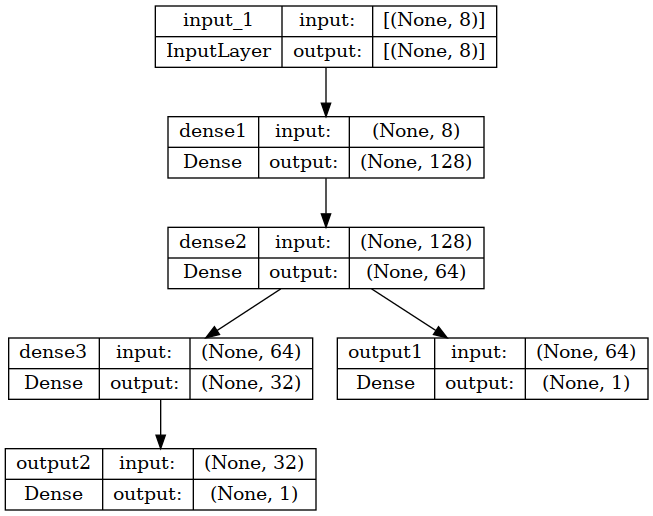

In [14]:
plot_model(model, show_shapes=True)

In [15]:
with tf.device('gpu:0'):
    history = model.fit(x_norm, y_train, epochs=2000, verbose=0)

In [16]:
loss, output1_loss, output2_loss, output1_rms, output2_rms = model.evaluate(norm(x_test, mu, sigma), y_test)

6/6 [==============================] - 0s 2ms/step - loss: 5.3497 - output1_loss: 2.6715 - output2_loss: 2.6783 - output1_root_mean_squared_error: 1.6345 - output2_root_mean_squared_error: 1.6365


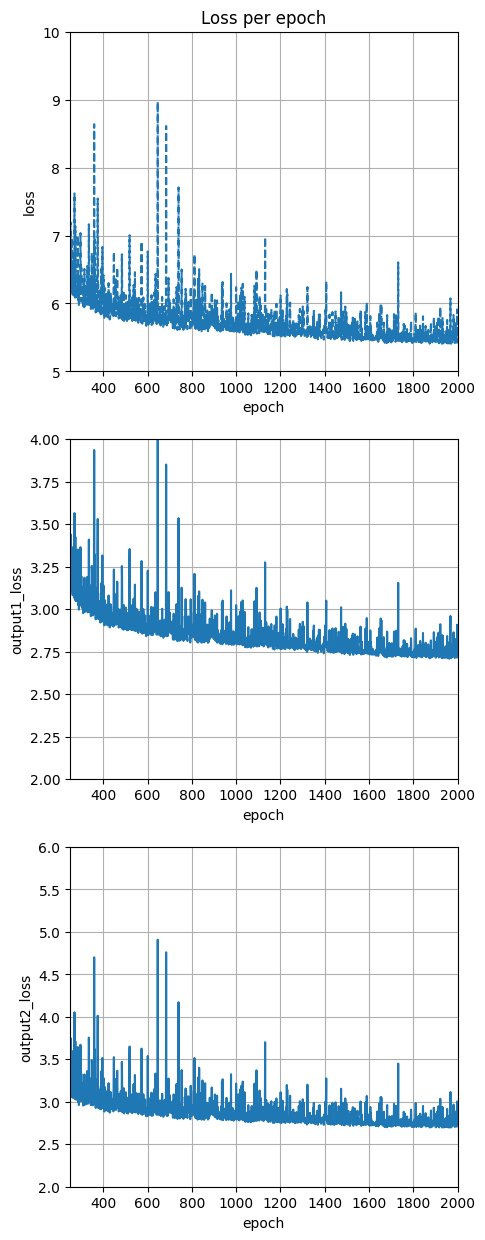

In [29]:
fig = plt.figure(figsize=(5, 15))

ax = plt.subplot(3, 1, 1)
ax.set_title('Loss per epoch');
ax.grid(True)
ax.plot(history.epoch, history.history['loss'],'--', label='overall')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_xlim([250, 2000])
ax.set_ylim([5, 10])

ax = plt.subplot(3, 1, 2)
ax.grid(True)
ax.plot(history.epoch, history.history['output1_loss'], label='output1')
ax.set_xlabel('epoch')
ax.set_ylabel('output1_loss')
ax.set_xlim([250, 2000])
ax.set_ylim([2, 4])

ax = plt.subplot(3, 1, 3)
ax.grid(True)
ax.plot(history.epoch, history.history['output2_loss'], label='output2')
ax.set_xlabel('epoch')
ax.set_ylabel('output2_loss')
ax.set_xlim([250, 2000])
ax.set_ylim([2, 6]);